#Instalación de requerimientos

In [119]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q -c https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [120]:
!java -version

openjdk version "11.0.16" 2022-07-19
OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04)
OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)


In [121]:
# Install PySpark
!pip -q install pyspark

In [162]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [123]:
import findspark
findspark.init()
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import round,max,udf
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import initcap

from numpy import sqrt,zeros,c_,amax,max

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans

from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation

from pyspark.sql.types import DoubleType

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import pylab as pl

In [124]:
#Small printing
%precision 2
np.set_printoptions(precision=2)

In [125]:
# create sparksession and sparkcontext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

#Descarga y manipulación de datos

In [126]:
#df = pd.read_csv('https://courses.edx.org/asset-v1:MITx+15.071x_2a+2T2015+type@asset+block/climate_change.csv')
df = pd.read_csv('https://raw.githubusercontent.com/cesar-xyz/MapatonAgua/main/files/UnionRegiosDOF.csv')
spark_df = spark.createDataFrame(df)

# Descomentar para ver el esquema del dataframe
spark_df.printSchema()

# Descomentar para imprimir el número de resgistros
#spark_df.count()

# Descomentar para imprimir el número de columnas
#len(spark_df.columns)

root
 |-- Unnamed: 0: long (nullable = true)
 |-- TITULO: string (nullable = true)
 |-- USO QUE AMPARA EL TITULO: string (nullable = true)
 |-- TITULAR: string (nullable = true)
 |-- VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TITULO EN m3: double (nullable = true)
 |-- APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TITULO: long (nullable = true)
 |-- VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUPERFICIALES EN m3: double (nullable = true)
 |-- APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TITULO: long (nullable = true)
 |-- VOLUMEN DE EXTRACCIÓN ANUAL DE APROVECHAMIENTOS SUBTERRÁNEOS EN m3: double (nullable = true)
 |-- PUNTOS DE DESCARGA QUE AMPARA EL TITULO: long (nullable = true)
 |-- VOLUMEN DE DESCARGA DIARIO EN m3: double (nullable = true)
 |-- ZONAS FEDERALES QUE AMPARA EL TITULO: long (nullable = true)
 |-- SUPERFICIE EN m2: double (nullable = true)
 |-- FECHA DE REGISTRO: string (nullable = true)
 |-- AUTORIDAD QUE EMITE EL ACTO: string (nullable = true)
 |-

Se tienen 9739 registros en total.
44 columnas iniciales.

In [127]:
# Borrar duplicados, nulos y la columna de indíce
spark_df = spark_df.drop_duplicates()
spark_df = spark_df.dropna()
spark_df= spark_df.drop("Unnamed: 0")

# Descomentar para ver la tabla
spark_df.show()

+--------------------+------------------------+--------------------+--------------------------------------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------+--------------------------------------------------+------------------------------------------------------------------+---------------------------------------+--------------------------------+------------------------------------+----------------+-----------------+---------------------------+---------------------------+----------------------------+------+----------------+------------------+-------------------+---------------------------+----------------------------+-------------------+--------------+---------------+----------------+---------------+----------------+-----------------+----------------------------------------+-------------------------------+---------------+----------------------------+-----------------------------+--

In [128]:
# Buscar valores categóricos que se puedan indexar
spark_df_strings = spark_df['TITULO', 'USO QUE AMPARA EL TITULO', 'TITULAR', 'FECHA DE REGISTRO', 'AUTORIDAD QUE EMITE EL ACTO', 'NOMBRE DE REGIÓN HIDROLÓGICA', 'NOMBRE DE ESTADO', 'NOMBRE DE MUNICIPIO', 'NOMBRE DE CUENCA HIDROLÓGICA', 'ACUIFERO QUE MENCIONA EL TITULO', 'NOMBRE DE ACUIFERO HOMOLOGADO', 'PubPrivEjid', 'ACUIFERO']
spark_df_strings.agg(*(countDistinct(col(c)).alias(c) for c in spark_df_strings.columns)).show()

+------+------------------------+-------+-----------------+---------------------------+----------------------------+----------------+-------------------+----------------------------+-------------------------------+-----------------------------+-----------+--------+
|TITULO|USO QUE AMPARA EL TITULO|TITULAR|FECHA DE REGISTRO|AUTORIDAD QUE EMITE EL ACTO|NOMBRE DE REGIÓN HIDROLÓGICA|NOMBRE DE ESTADO|NOMBRE DE MUNICIPIO|NOMBRE DE CUENCA HIDROLÓGICA|ACUIFERO QUE MENCIONA EL TITULO|NOMBRE DE ACUIFERO HOMOLOGADO|PubPrivEjid|ACUIFERO|
+------+------------------------+-------+-----------------+---------------------------+----------------------------+----------------+-------------------+----------------------------+-------------------------------+-----------------------------+-----------+--------+
|  9739|                      10|   7225|             1000|                          9|                           5|               1|                 48|                          16|                    

* Sólo hay un estado, Nuevo León, se pueden borrar esas columnas
* Existe ya una columna de código de municipio, no se necesita la de nombre
* El título es único, se puede utilizar como índice
* Hay sólo 10 usos del amparo, se puede indexar
* No se necesita el titular
* Autoridad se puede indexar
* Nombre de región hidrológica, nombre de acuífero homologado, nombre de cuenta hidrológica tienen su clave, no se necesitan
* Acuífero está repetido, se puede eliminar

In [129]:
#cols_borrar = ['TITULAR', 'FECHA DE REGISTRO', 'ESTADO', 'NOMBRE DE ESTADO', 'NOMBRE DE REGIÓN HIDROLÓGICA', 'NOMBRE DE MUNICIPIO', 'NOMBRE DE CUENCA HIDROLÓGICA', 'NOMBRE DE ACUIFERO HOMOLOGADO', 'ACUIFERO']

# Borrar columnas no necesarias
df = spark_df.drop('TITULAR', 'FECHA DE REGISTRO', 'ESTADO', 'NOMBRE DE ESTADO', 'NOMBRE DE REGIÓN HIDROLÓGICA', 'NOMBRE DE MUNICIPIO', 'NOMBRE DE CUENCA HIDROLÓGICA', 'NOMBRE DE ACUIFERO HOMOLOGADO', 'ACUIFERO')
df = df.drop('TITULO', 'GRADOS LATITUD', 'MINUTOS LATITUD', 'SEGUNDOS LATITUD', 'NÚMERO DE ANEXO', 'GRADOS LONGITUD', 'MINUTOS LONGITUD', 'SEGUNDOS LONGITUD')
#df.show()
#df.printSchema()

#Indexación de datos

###'USO QUE AMPARA EL TITULO'

In [130]:
# Crear indexer y alterar el df
indexer = StringIndexer(inputCol='USO QUE AMPARA EL TITULO', outputCol='USO QUE AMPARA EL TITULO INDEXADO')
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
# Crear un df para guardar una relación
USO_QUE_AMPARA_EL_TITULO = df['USO QUE AMPARA EL TITULO INDEXADO', 'USO QUE AMPARA EL TITULO']
USO_QUE_AMPARA_EL_TITULO = USO_QUE_AMPARA_EL_TITULO.drop_duplicates()
USO_QUE_AMPARA_EL_TITULO = USO_QUE_AMPARA_EL_TITULO.sort('USO QUE AMPARA EL TITULO INDEXADO')
# Eliminar columna categórtica y visualizar datos
df = df.drop('USO QUE AMPARA EL TITULO')
USO_QUE_AMPARA_EL_TITULO.show()

+---------------------------------+------------------------+
|USO QUE AMPARA EL TITULO INDEXADO|USO QUE AMPARA EL TITULO|
+---------------------------------+------------------------+
|                              0.0|                AGRÍCOLA|
|                              1.0|         DIFERENTES USOS|
|                              2.0|               DOMÉSTICO|
|                              3.0|                PECUARIO|
|                              4.0|              INDUSTRIAL|
|                              5.0|               SERVICIOS|
|                              6.0|          PÚBLICO URBANO|
|                              7.0|             ACUACULTURA|
|                              8.0|           AGROINDUSTIAL|
|                              9.0|    GENERACIÓN  DE EN...|
+---------------------------------+------------------------+



###'AUTORIDAD QUE EMITE EL ACTO'

In [131]:
# Crear indexer y alterar el df
indexer = StringIndexer(inputCol='AUTORIDAD QUE EMITE EL ACTO', outputCol='AUTORIDAD QUE EMITE EL ACTO INDEXADO')
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
# Crear un df para guardar una relación
AUTORIDAD_QUE_EMITE_EL_ACTO = df['AUTORIDAD QUE EMITE EL ACTO INDEXADO', 'AUTORIDAD QUE EMITE EL ACTO']
AUTORIDAD_QUE_EMITE_EL_ACTO = AUTORIDAD_QUE_EMITE_EL_ACTO.drop_duplicates()
AUTORIDAD_QUE_EMITE_EL_ACTO = AUTORIDAD_QUE_EMITE_EL_ACTO.sort('AUTORIDAD QUE EMITE EL ACTO INDEXADO')
# Eliminar columna categórtica y visualizar datos
df = df.drop('AUTORIDAD QUE EMITE EL ACTO')
AUTORIDAD_QUE_EMITE_EL_ACTO.show()

+------------------------------------+---------------------------+
|AUTORIDAD QUE EMITE EL ACTO INDEXADO|AUTORIDAD QUE EMITE EL ACTO|
+------------------------------------+---------------------------+
|                                 0.0|       DIRECCIÓN GENERAL...|
|                                 1.0|       DIRECCIÓN DE ADMI...|
|                                 2.0|       ORGANISMO DE CUEN...|
|                                 3.0|       GERENCIA ESTATAL ...|
|                                 4.0|       DIRECCIÓN GENERAL...|
|                                 5.0|         OFICINAS CENTRALES|
|                                 6.0|       DIRECCIÓN DE ADMI...|
|                                 7.0|       GERENCIA DE SERVI...|
|                                 8.0|       SUBDIRECCIÓN GENE...|
+------------------------------------+---------------------------+



###'PubPrivEjid'

In [132]:
# Crear indexer y alterar el df
indexer = StringIndexer(inputCol='PubPrivEjid', outputCol='PubPrivEjid_Indexado')
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
# Crear un df para guardar una relación
PubPrivEjid = df['PubPrivEjid_Indexado', 'PubPrivEjid']
PubPrivEjid = PubPrivEjid.drop_duplicates()
PubPrivEjid = PubPrivEjid.sort('PubPrivEjid_Indexado')
# Eliminar columna categórtica y visualizar datos
df = df.drop('PubPrivEjid')
PubPrivEjid.show()

+--------------------+-----------+
|PubPrivEjid_Indexado|PubPrivEjid|
+--------------------+-----------+
|                 0.0|    PRIVADO|
|                 1.0|     EJIDAL|
|                 2.0|    PUBLICO|
|                 3.0|   PRIVADO
|
+--------------------+-----------+



In [133]:
df = df.filter((df.PubPrivEjid_Indexado != 3.0))
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+--------------------------------------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------+--------------------------------------------------+------------------------------------------------------------------+---------------------------------------+--------------------------------+------------------------------------+----------------+---------------------------+------------------+---------------------------+-------------------+----------------------------------------+-------------------------------+----------------------------+-------+--------+-------------------------+----------------------------+------------------------------------------+--------------------------------------+-----------------------------------------------------+---------------------------------+------------------------------------+--------------------+
|VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA E

Se borraron sólo 2 registros que tenían unos errores en la variable de PubPrivEjid

###'ACUIFERO QUE MENCIONA EL TITULO'

In [134]:
# Crear indexer y alterar el df
indexer = StringIndexer(inputCol='ACUIFERO QUE MENCIONA EL TITULO', outputCol='ACUIFERO QUE MENCIONA EL TITULO INDEXADO')
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
# Crear un df para guardar una relación
ACUIFERO_QUE_MENCIONA_EL_TITULO = df['ACUIFERO QUE MENCIONA EL TITULO INDEXADO', 'ACUIFERO QUE MENCIONA EL TITULO']
ACUIFERO_QUE_MENCIONA_EL_TITULO = ACUIFERO_QUE_MENCIONA_EL_TITULO.drop_duplicates()
ACUIFERO_QUE_MENCIONA_EL_TITULO = ACUIFERO_QUE_MENCIONA_EL_TITULO.sort('ACUIFERO QUE MENCIONA EL TITULO INDEXADO')
# Eliminar columna categórtica y visualizar datos
df = df.drop('ACUIFERO QUE MENCIONA EL TITULO')
ACUIFERO_QUE_MENCIONA_EL_TITULO.show()

+----------------------------------------+-------------------------------+
|ACUIFERO QUE MENCIONA EL TITULO INDEXADO|ACUIFERO QUE MENCIONA EL TITULO|
+----------------------------------------+-------------------------------+
|                                     0.0|                CITRICOLA NORTE|
|                                     1.0|                       SIN DATO|
|                                     2.0|                  CITRICOLA SUR|
|                                     3.0|           AREA METROPOLITAN...|
|                                     4.0|           EL CARMEN-SALINAS...|
|                                     5.0|           NAVIDAD-POTOSI-RA...|
|                                     6.0|                  SABINAS-PARAS|
|                                     7.0|              CAÑON DEL HUAJUCO|
|                                     8.0|               LAMPAZOS-ANAHUAC|
|                                     9.0|           ZONA CITRICOLA NORTE|
|                        

#Redux

In [135]:
munis = spark_df.select('CLAVE DE MUNICIPIO', 'NOMBRE DE MUNICIPIO')
munis = munis.dropDuplicates()
munis = munis.withColumnRenamed('CLAVE DE MUNICIPIO', 'Clave_Municipio')
munis = (((munis.select("*", initcap(col('NOMBRE DE MUNICIPIO'))))).withColumnRenamed('initcap(NOMBRE DE MUNICIPIO)', 'Municipio')).drop('NOMBRE DE MUNICIPIO')
munis.show(3)

+---------------+--------------+
|Clave_Municipio|     Municipio|
+---------------+--------------+
|              7|     Aramberri|
|             11|      Cerralvo|
|             48|Santa Catarina|
+---------------+--------------+
only showing top 3 rows



In [136]:
new_df = df.select('VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TITULO EN m3', 'CLAVE DE MUNICIPIO', 'SUPERFICIE EN m2', 'USO QUE AMPARA EL TITULO INDEXADO', 'PubPrivEjid_Indexado', 'APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TITULO', 'APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TITULO')

new_df = new_df.withColumnRenamed('VOLUMEN DE EXTRACCIÓN ANUAL DE AGUAS NACIONALES QUE AMPARA EL TITULO EN m3', 'Volumen_m3')
new_df = new_df.withColumnRenamed('CLAVE DE MUNICIPIO', 'Clave_Municipio')
new_df = new_df.withColumnRenamed('SUPERFICIE EN m2', 'Superficie_m2')
new_df = new_df.withColumnRenamed('USO QUE AMPARA EL TITULO INDEXADO', 'Uso_Amparado')
new_df = new_df.withColumnRenamed('APROVECHAMIENTOS SUPERFICIALES QUE AMPARA EL TITULO', 'Aprov_Sup')
new_df = new_df.withColumnRenamed('APROVECHAMIENTOS SUBTERRÁNEOS QUE AMPARA EL TITULO', 'Aprov_Sub')

new_df.show(1)

+----------+---------------+-------------+------------+--------------------+---------+---------+
|Volumen_m3|Clave_Municipio|Superficie_m2|Uso_Amparado|PubPrivEjid_Indexado|Aprov_Sup|Aprov_Sub|
+----------+---------------+-------------+------------+--------------------+---------+---------+
|    1095.0|             42|          0.0|         3.0|                 0.0|        0|        1|
+----------+---------------+-------------+------------+--------------------+---------+---------+
only showing top 1 row



In [137]:
# TABLA CON DATOS DE SUMATORIA POR TIPO DE TERRENO
new_df.createOrReplaceTempView("redux3")

temp = spark.sql("""  select PubPrivEjid_Indexado, Clave_Municipio, sum(Volumen_m3) as Vol_X_Tipo
                      from redux3
                      group by PubPrivEjid_Indexado, Clave_Municipio
                      order by Clave_Municipio""")

temp = temp.join(munis, on="Clave_Municipio")
temp.show()

+---------------+--------------------+--------------------+--------------------+
|Clave_Municipio|PubPrivEjid_Indexado|          Vol_X_Tipo|           Municipio|
+---------------+--------------------+--------------------+--------------------+
|             26|                 0.0|          5454548.25|           Guadalupe|
|             26|                 2.0|            301079.0|           Guadalupe|
|             29|                 0.0|        1.32782809E7|         Hualahuises|
|             29|                 1.0|            360000.0|         Hualahuises|
|             19|                 0.0|        1.21493979E7|San Pedro Garza G...|
|             22|                 2.0|            180000.0|       General Terán|
|             22|                 0.0|       8.583433787E7|       General Terán|
|             22|                 1.0|           2520000.0|       General Terán|
|              7|                 1.0|         1.5212369E7|           Aramberri|
|              7|           

In [138]:
# TOTAL DE VOLUMEN EXTRAIDO POR AÑO POR M3 POR MUNICIPIO EN EL SECTOR PRIVADO
temp.createOrReplaceTempView("redux4")

temp2 = spark.sql(""" select Municipio, sum(Vol_X_Tipo) as Total_Privado
                      from redux4
                      where PubPrivEjid_Indexado = 0
                      group by Municipio
                  """)

# TOTAL DE VOLUMEN EXTRAIDO POR AÑO POR M3 POR MUNICIPIO EN EL SECTOR EJIDAL
temp.createOrReplaceTempView("redux5")

temp3 = spark.sql(""" select Municipio, sum(Vol_X_Tipo) as Total_Ejidal
                      from redux5
                      where PubPrivEjid_Indexado = 1
                      group by Municipio
                  """)

# TOTAL DE VOLUMEN EXTRAIDO POR AÑO POR M3 POR MUNICIPIO EN EL SECTOR EJIDAL
temp.createOrReplaceTempView("redux6")

temp4 = spark.sql(""" select Municipio, sum(Vol_X_Tipo) as Total_Publico
                      from redux6
                      where PubPrivEjid_Indexado = 2
                      group by Municipio
                  """)

In [139]:
# OBTENER SUMATORIAS POR MUNICIPIO
new_df.createOrReplaceTempView("redux")
new_new_df = spark.sql("""  select Clave_Municipio, 
                          sum(Volumen_m3) as Total_Volumen_m3,
                          sum(Superficie_m2) as Superficie_Total_m2,
                          sum(Aprov_Sup) as Aprov_Sup_T,
                          sum(Aprov_Sub) as Aprov_Sub_T
                          from redux group by Clave_Municipio order by Total_Volumen_m3""")

new_new_df = new_new_df.join(munis, on='Clave_Municipio')
new_new_df = (((new_new_df.drop('Clave_Municipio')).withColumnRenamed('NOMBRE DE MUNICIPIO', 'Municipio')).select('Municipio', 'Total_Volumen_m3', 'Superficie_Total_m2', 'Aprov_Sup_T', 'Aprov_Sub_T')).sort('Total_Volumen_m3')
new_new_df.show()

+----------------+------------------+-------------------+-----------+-----------+
|       Municipio|  Total_Volumen_m3|Superficie_Total_m2|Aprov_Sup_T|Aprov_Sub_T|
+----------------+------------------+-------------------+-----------+-----------+
|        Iturbide|            2400.0|                0.0|          0|          1|
|  Melchor Ocampo|           18000.0|                0.0|          0|          1|
|         Rayones|          117000.0|                0.0|          0|          3|
|         Abasolo|          142845.0|                0.0|          0|         10|
|     Doctor Coss|          369876.5|                0.0|          0|         36|
| General Treviño|          451814.0|                0.0|          0|         12|
|    Los Herreras|          561727.0|                0.0|          0|         11|
|         Hidalgo|          766119.9|                0.0|          0|         33|
|           Parás|          997301.5|                0.0|          0|         52|
|        Cerralv

# Descarga de base de datos inegi

In [140]:
!gdown 1Bq-LbGP6jUGbgGmOtWR15LIrjh0QIdTU

Downloading...
From: https://drive.google.com/uc?id=1Bq-LbGP6jUGbgGmOtWR15LIrjh0QIdTU
To: /content/iter_19_cpv2020_csv.zip
100% 695k/695k [00:00<00:00, 62.9MB/s]


In [141]:
!unzip /content/iter_19_cpv2020_csv.zip -d /content/iter_19_cpv2020_csv/ &> /dev/null

In [142]:
!ls /content/iter_19_cpv2020_csv/iter_19_cpv2020/conjunto_de_datos

conjunto_de_datos_iter_19CSV20.csv


In [143]:
df_pob = pd.read_csv('/content/iter_19_cpv2020_csv/iter_19_cpv2020/conjunto_de_datos/conjunto_de_datos_iter_19CSV20.csv')
df_pob = df_pob.drop('LONGITUD', axis = 1)
df_pob = df_pob.drop('LATITUD', axis = 1)
df_pob = df_pob.drop('REL_H_M', axis = 1)
df_pob = df_pob.drop('PROM_HNV', axis = 1)

df_pob_spark = spark.createDataFrame(df_pob)

In [144]:
#df_pob_spark.where('NOM_LOC' != 'Total del Municipio')
df_pob_spark = df_pob_spark.filter(df_pob_spark.NOM_LOC != "Total del Municipio")

In [145]:
# Temporary table from data with cluster predictions
df_pob_spark.createOrReplaceTempView("redux2")

# Get the total sum for every municipio
inegi2020 = spark.sql("""  select NOM_MUN as Municipio, 
                          sum(POBTOT) as Poblacion,
                          sum(VPH_AGUAFV) as Casas_Sin_Agua,
                          sum(VPH_NODREN) as Casas_Sin_Drenaje
                          from redux2 group by Municipio order by Poblacion""")

#inegi2020.show(51, truncate=False)

In [146]:
new_new_df = ((new_new_df.select("*", initcap(col('Municipio')))).select('initcap(Municipio)', 'Total_Volumen_m3', 'Aprov_Sup_T', 'Aprov_Sub_T')).withColumnRenamed('initcap(Municipio)', 'Municipio')

new_new_df = new_new_df.join(inegi2020, on='Municipio').sort('Total_Volumen_m3')
new_new_df = new_new_df.join(munis, on='Municipio')

new_new_df = (new_new_df.withColumn('Aprovechamientos', sum(new_new_df[col] for col in ['Aprov_Sup_T', 'Aprov_Sub_T']))).drop('Aprov_Sup_T', 'Aprov_Sub_T')

In [147]:
elchido = new_new_df.join(temp2, on='Municipio', how='left_outer')
elchido = elchido.join(temp3, on='Municipio', how='left_outer')
elchido = elchido.join(temp4, on='Municipio', how='left_outer')
elchido = elchido.na.fill(0)
elchido = elchido.withColumn('Total_Volumen_m3', elchido.Total_Volumen_m3.cast(DoubleType()))
elchido = elchido.withColumn('Poblacion', elchido.Poblacion.cast(DoubleType()))
elchido = elchido.withColumn('Total_Privado', elchido.Total_Privado.cast(DoubleType()))
elchido = elchido.withColumn('Total_Ejidal', elchido.Total_Ejidal.cast(DoubleType()))
elchido = elchido.withColumn('Total_Publico', elchido.Total_Publico.cast(DoubleType()))

elchido.show(10, truncate=False)

+--------------+----------------+---------+--------------+-----------------+---------------+----------------+-------------+------------+-------------+
|Municipio     |Total_Volumen_m3|Poblacion|Casas_Sin_Agua|Casas_Sin_Drenaje|Clave_Municipio|Aprovechamientos|Total_Privado|Total_Ejidal|Total_Publico|
+--------------+----------------+---------+--------------+-----------------+---------------+----------------+-------------+------------+-------------+
|Vallecillo    |3.072708995E7   |1683.0   |18.0          |51.0             |50             |244             |3.072708995E7|0.0         |0.0          |
|Santa Catarina|3193106.85      |306393.0 |225.0         |217.0            |48             |119             |3113864.15   |0.0         |79242.7      |
|Bustamante    |5001217.38      |3762.0   |24.0          |29.0             |8              |103             |4995668.38   |5549.0      |0.0          |
|Pesquería     |1.697173548E7   |147905.0 |194.0         |92.0             |41             |34

In [148]:
elchido.printSchema()

root
 |-- Municipio: string (nullable = true)
 |-- Total_Volumen_m3: double (nullable = false)
 |-- Poblacion: double (nullable = true)
 |-- Casas_Sin_Agua: double (nullable = false)
 |-- Casas_Sin_Drenaje: double (nullable = false)
 |-- Clave_Municipio: long (nullable = true)
 |-- Aprovechamientos: long (nullable = true)
 |-- Total_Privado: double (nullable = false)
 |-- Total_Ejidal: double (nullable = false)
 |-- Total_Publico: double (nullable = false)



#Mapa de calor

In [149]:
df_pd = elchido.toPandas()
df_pd.set_index('Municipio')
corr_mat = df_pd.corr()

In [150]:
corr_matrix_pd = pd.DataFrame(data=corr_mat, index=elchido.columns,columns=elchido.columns)
corr_matrix_pd

,Municipio,Total_Volumen_m3,Poblacion,Casas_Sin_Agua,Casas_Sin_Drenaje,Clave_Municipio,Aprovechamientos,Total_Privado,Total_Ejidal,Total_Publico
Municipio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total_Volumen_m3,NaN,1.000000,0.621993,0.267873,0.181213,0.102997,0.378277,0.359095,0.258768,0.932542
Poblacion,NaN,0.621993,1.000000,0.251840,0.049729,0.032763,0.115872,-0.006210,-0.073528,0.677361
Casas_Sin_Agua,NaN,0.267873,0.251840,1.000000,0.893543,-0.139831,0.106444,0.237192,0.422622,0.165674
Casas_Sin_Drenaje,NaN,0.181213,0.049729,0.893543,1.000000,-0.104550,0.221917,0.245812,0.251453,0.090040
Clave_Municipio,NaN,0.102997,0.032763,-0.139831,-0.104550,1.000000,-0.006203,-0.011301,-0.138982,0.130054
Aprovechamientos,NaN,0.378277,0.115872,0.106444,0.221917,-0.006203,1.000000,0.805180,0.175391,0.139511
Total_Privado,NaN,0.359095,-0.006210,0.237192,0.245812,-0.011301,0.805180,1.000000,0.608970,0.009052
Total_Ejidal,NaN,0.258768,-0.073528,0.422622,0.251453,-0.138982,0.175391,0.608970,1.000000,-0.024704
Total_Publico,NaN,0.932542,0.677361,0.165674,0.090040,0.130054,0.139511,0.009052,-0.024704,1.000000


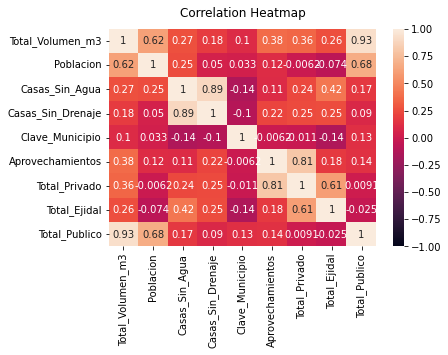

In [151]:
heatmap = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#K Means

In [152]:
elchido.columns

['Municipio',
 'Total_Volumen_m3',
 'Poblacion',
 'Casas_Sin_Agua',
 'Casas_Sin_Drenaje',
 'Clave_Municipio',
 'Aprovechamientos',
 'Total_Privado',
 'Total_Ejidal',
 'Total_Publico']

In [153]:
#new_new_df = new_new_df.drop('features')

In [154]:
# Create attributes vector
vecAssembler = VectorAssembler(inputCols=[
 'Total_Volumen_m3',
 'Poblacion',
 'Casas_Sin_Agua',
 'Casas_Sin_Drenaje',
 'Clave_Municipio',
 'Aprovechamientos',
 'Total_Privado',
 'Total_Ejidal',
 'Total_Publico'], outputCol="features")

# Create table with vector column added
elchido = vecAssembler.transform(elchido)
#elchido.show(truncate=False)

In [155]:
elchido.describe().show()

+-------+----------+-------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+--------------------+
|summary| Municipio|   Total_Volumen_m3|         Poblacion|    Casas_Sin_Agua| Casas_Sin_Drenaje|   Clave_Municipio| Aprovechamientos|       Total_Privado|      Total_Ejidal|       Total_Publico|
+-------+----------+-------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+--------------------+
|  count|        45|                 45|                45|                45|                45|                45|               45|                  45|                45|                  45|
|   mean|      null|2.713549387533333E7|117636.71111111112|250.06666666666666|293.31111111111113|26.066666666666666|273.9555555555556|1.3548232086444447E7|1831084.7555555555|1.1756177033333333E7|
| stddev|      null|

In [158]:
elchido.dropna()

DataFrame[Municipio: string, Total_Volumen_m3: double, Poblacion: double, Casas_Sin_Agua: double, Casas_Sin_Drenaje: double, Clave_Municipio: bigint, Aprovechamientos: bigint, Total_Privado: double, Total_Ejidal: double, Total_Publico: double, features: vector]

In [174]:
df_pob_spark.show()

+-------+----------+---+--------------------+----+--------------------+-------+-------+-------+-------+------+-------+-------+-------+---------+---------+-------+---------+---------+--------+----------+----------+--------+----------+----------+--------+----------+----------+------+-------+-------+------+--------+--------+------+--------+--------+-------+---------+---------+-------+---------+---------+-------+---------+---------+---------+--------+----------+----------+-------+--------+---------+------+-------+-------+------+-------+-------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+-------+---------+---------+--------+----------+----------+---

In [221]:
ineeegi_pd = df_pob_spark.select('NOM_MUN', 'NOM_LOC', 'POBTOT', 'POBFEM', 'POBMAS','VPH_AGUADV', 'VPH_AEASP', 'VPH_AGUAFV', 'VPH_TINACO', 'VPH_CISTER', 'VPH_EXCSA', 'VPH_LETR', 'VPH_DRENAJ', 'VPH_NODREN').toPandas()

In [222]:
ineeegi = spark.createDataFrame(ineeegi_pd)
ineeegi.createOrReplaceTempView("ineex")

In [229]:
tempIneg = spark.sql(""" select NOM_MUN,
                                sum(POBTOT) as Poblacion_Total,
                                sum(POBFEM) as Poblacion_Femenina,
                                sum(POBMAS) as Poblacion_Masculina,
                                sum(VPH_AGUADV) as VPH_AGUADV,
                                sum(VPH_AEASP) as VPH_AEASP,
                                sum(VPH_AGUAFV) as VPH_AGUAFV,
                                sum(VPH_TINACO) as VPH_TINACO,
                                sum(VPH_CISTER) as VPH_CISTER,
                                sum(VPH_EXCSA) as VPH_EXCSA,
                                sum(VPH_LETR) as VPH_LETR,
                                sum(VPH_DRENAJ) as VPH_DRENAJ,
                                sum(VPH_NODREN) as VPH_NODREN
                      from ineex
                      group by NOM_MUN
                  """)
tempIneg.toPandas().to_csv('Inegi_Sumas.csv')

In [230]:
tempIneg.columns

['NOM_MUN',
 'Poblacion_Total',
 'Poblacion_Femenina',
 'Poblacion_Masculina',
 'VPH_AGUADV',
 'VPH_AEASP',
 'VPH_AGUAFV',
 'VPH_TINACO',
 'VPH_CISTER',
 'VPH_EXCSA',
 'VPH_LETR',
 'VPH_DRENAJ',
 'VPH_NODREN']

In [231]:
# Create attributes vector
vecAssembler = VectorAssembler(inputCols=[
 'VPH_AEASP',
 'VPH_EXCSA',
 'VPH_DRENAJ',
], outputCol="features")

# Create table with vector column added
tempIneg = vecAssembler.transform(tempIneg)
#elchido.show(truncate=False)

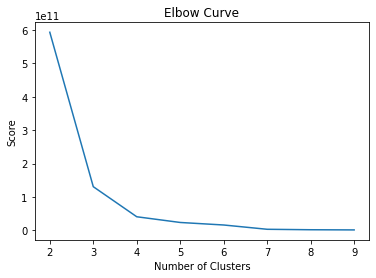

In [232]:
# DIAGRAMA DE CODO PARA NÚMERO DE K

# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(tempIneg)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [233]:
# Create kmeans clustering with 5 clusters
kmeans = KMeans(k=4, seed=1, maxIter=250)

# Fit model with data
model = kmeans.fit(tempIneg.select('features'))

# Create table with the predicted cluster added
transformed = model.transform(tempIneg)

# Visualize table
transformed.show()

+--------------------+---------------+------------------+-------------------+----------+---------+----------+----------+----------+---------+--------+----------+----------+--------------------+----------+
|             NOM_MUN|Poblacion_Total|Poblacion_Femenina|Poblacion_Masculina|VPH_AGUADV|VPH_AEASP|VPH_AGUAFV|VPH_TINACO|VPH_CISTER|VPH_EXCSA|VPH_LETR|VPH_DRENAJ|VPH_NODREN|            features|prediction|
+--------------------+---------------+------------------+-------------------+----------+---------+----------+----------+----------+---------+--------+----------+----------+--------------------+----------+
|          Vallecillo|           1683|             732.0|              820.0|     544.0|    423.0|      18.0|     139.0|      58.0|    497.0|    52.0|     511.0|      51.0| [423.0,497.0,511.0]|         0|
|      Santa Catarina|         306393|          153705.0|           152617.0|   81920.0|  81466.0|     225.0|   17672.0|    1127.0|  81956.0|   133.0|   81907.0|     217.0|[81466.0

In [234]:
# Temporary table from data with cluster predictions
transformed.createOrReplaceTempView("result_kmeans")

# Get the mean from every column in every cluster
clusters = spark.sql(""" select prediction, 
    mean(VPH_AEASP) as mean_agua,
    mean(VPH_DRENAJ) as mean_drenaje,
    mean(VPH_EXCSA) as mean_excusado,
    count(*) as conteo
from result_kmeans group by prediction order by mean_agua""")

# Visualize table
clusters.show()

+----------+------------------+-----------------+-----------------+------+
|prediction|         mean_agua|     mean_drenaje|    mean_excusado|conteo|
+----------+------------------+-----------------+-----------------+------+
|         0| 7807.627906976744|8403.767441860466|8235.023255813954|    43|
|         3|134049.57142857142|135248.7142857143|135211.2857142857|     7|
|         2|          322554.0|         325221.0|         325175.0|     1|
|         1|         1596934.0|        1635903.0|        1628210.0|     1|
+----------+------------------+-----------------+-----------------+------+



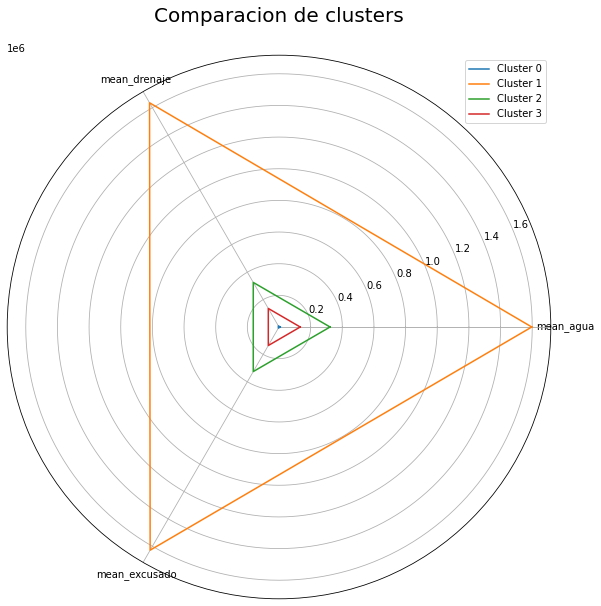

In [235]:
# Transform clusters data to pandas Df
df_clusters = clusters.toPandas()

# Create array from data
categories = df_clusters.columns[1:-1].values

# Split array into multiple arrays for each cluster
cluster_0 = df_clusters.where(df_clusters.prediction==0).dropna().values[0][1:-1]
cluster_1 = df_clusters.where(df_clusters.prediction==1).dropna().values[0][1:-1]
cluster_2 = df_clusters.where(df_clusters.prediction==2).dropna().values[0][1:-1]
cluster_3 = df_clusters.where(df_clusters.prediction==3).dropna().values[0][1:-1]

cluster_0 = [*cluster_0,cluster_0[0]]
cluster_1 = [*cluster_1,cluster_1[0]]
cluster_2 = [*cluster_2,cluster_2[0]]
cluster_3 = [*cluster_3,cluster_3[0]]

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster_0))

# Plot cluster comparison
plt.figure(figsize=(10, 10))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')
plt.title('Comparacion de clusters', size=20)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

Cluster 0 -> Número de viviendas que no tienen agua, drenaje, tinaco 
---
Cluster 1 -> Viviendas que sí tienen agua, drenaje, tinaco, etc
---
Cluster 2  -> Viviendas con poco
---
Cluster 3 -> Viviendas con muy poco

In [236]:
transformed.toPandas().to_csv('Ya_agrupado.csv')